
### (1) Accuracy of plurality v. number of attempts 
### (2) Plurality size v. probability of correctness (you might need to bin plurality size for this one) 
### (3) Entropy of the responses (so \sum_{answers given} -P(that answer is given)logP(that answer is given)) v. correctness of the plurality. 

#### See full list of models here:
#### https://docs.google.com/spreadsheets/u/1/d/1JTKo3-DWhI574plxmbLl3vvxsKvGIL7tejDEPGGwBJk/edit?gid=0#gid=0


In [2]:
import wandb, json
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional

api = wandb.Api()
entity = "jchud-stanford-university"
project = "KoyejoLab-SPA-scripts"



RUNS = [
    # (model_id, run_id)  -> benchmark inferred from table files in the run
    ("meta-llama/Llama-4-Scout-17B-16E", "vzy37n7a"),  # unfinished
    ("Qwen/Qwen2.5-3B-Instruct",         "1yb9k8r5"),  # math
    ("Qwen/Qwen2.5-3B-Instruct",         "xjvvb9y5"),  # aime
    # ("Qwen/Qwen3-32B",                   "wrmo8j8w"),  # math
    ("Qwen/Qwen3-32B",                   "8y9lyimx"),  # math + aime in one run
    ("openai/gpt-oss-120b",              "d64xsyc0"),  # math
    ("openai/GPT-oss-20B",               "e90cl6b9"),  # math
    ("openai/GPT-oss-20B",               "kppux09d"),  # aime
    ("google/gemma-3-27b-it",            "g9c0b7vs"),  # math
    ("google/gemma-3-27b-it",            "tr85ww1g"),  # aime
]

NEEDED = {"qid", "sample_id", "pred", "gold"}

def bench_from_name(fname: str) -> Optional[str]:
    # works for: math_0_..., math_test_0_..., aime_1_..., etc.
    base = fname.split("/")[-1].lower()
    if base.startswith("math_") or base.startswith("math-") or base.startswith("math"):
        return "math"
    if base.startswith("aime_") or base.startswith("aime-") or base.startswith("aime"):
        return "aime"
    return None

def list_table_json_files(run) -> List[str]:
    return [f.name for f in run.files() if f.name.endswith(".table.json")]

def load_table_json(run, table_path: str, root="wandb_downloads") -> pd.DataFrame:
    root = Path(root) / run.id
    (root / Path(table_path).parent).mkdir(parents=True, exist_ok=True)
    run.file(table_path).download(root=str(root), replace=True)
    data = json.loads((root / table_path).read_text())
    return pd.DataFrame(data["data"], columns=data["columns"])

def collect_samples_tables(
    runs_spec: List[Tuple[str, str]],
    max_rows: Optional[int] = None,
) -> Tuple[Dict[str, pd.DataFrame], Dict[str, pd.DataFrame], List[Tuple[str, str, str]]]:

    by_math: Dict[str, pd.DataFrame] = {}
    by_aime: Dict[str, pd.DataFrame] = {}
    skipped: List[Tuple[str, str, str]] = []

    for model, run_id in runs_spec:
        run = api.run(f"{entity}/{project}/{run_id}")
        if run.state != "finished":
            skipped.append((model, run_id, f"state={run.state}"))
            continue

        found = {"math": None, "aime": None}

        for path in list_table_json_files(run):
            b = bench_from_name(path)
            if b is None or found[b] is not None:
                continue

            df = load_table_json(run, path)
            if not NEEDED.issubset(df.columns):
                skipped.append((model, run_id, f"{b}: missing cols {sorted(NEEDED - set(df.columns))} (file={path})"))
                continue

            if max_rows is not None:
                df = df.head(max_rows)

            found[b] = df

            # early exit if we got both
            if found["math"] is not None and found["aime"] is not None:
                break

        if found["math"] is not None:
            by_math[model] = found["math"]
        if found["aime"] is not None:
            by_aime[model] = found["aime"]

        if found["math"] is None and found["aime"] is None:
            skipped.append((model, run_id, "no usable math/aime .table.json found"))

    return by_math, by_aime, skipped


df_by_model_math, df_by_model_aime, skipped = collect_samples_tables(RUNS)

print("MATH:", list(df_by_model_math.keys()))
print("AIME:", list(df_by_model_aime.keys()))
print("Skipped:", skipped)


MATH: ['meta-llama/Llama-4-Scout-17B-16E', 'Qwen/Qwen2.5-3B-Instruct', 'Qwen/Qwen3-32B', 'openai/gpt-oss-120b', 'openai/GPT-oss-20B', 'google/gemma-3-27b-it']
AIME: ['Qwen/Qwen2.5-3B-Instruct', 'Qwen/Qwen3-32B', 'openai/GPT-oss-20B', 'google/gemma-3-27b-it']
Skipped: []


## Let's take a look inside

In [2]:
def print_df_summary(df_dict, name):
    print(f"\n==== {name} ====")
    for model, df in df_dict.items():
        print(f"\n[{model}]")
        print("shape:", df.shape)
        print("columns:", list(df.columns))
        print(df.head())

print_df_summary(df_by_model_math, "MATH")
print_df_summary(df_by_model_aime, "AIME")


==== MATH ====

[meta-llama/Llama-4-Scout-17B-16E]
shape: (10000, 7)
columns: ['dataset', 'qid', 'sample_id', 'question', 'gold', 'pred', 'response']
  dataset  qid  sample_id                                           question  \
0    math    0          0  If $y=\frac{27x^2+9x+3}{27x^3+9x^2+3x+1}$, at ...   
1    math    0          1  If $y=\frac{27x^2+9x+3}{27x^3+9x^2+3x+1}$, at ...   
2    math    0          2  If $y=\frac{27x^2+9x+3}{27x^3+9x^2+3x+1}$, at ...   
3    math    0          3  If $y=\frac{27x^2+9x+3}{27x^3+9x^2+3x+1}$, at ...   
4    math    0          4  If $y=\frac{27x^2+9x+3}{27x^3+9x^2+3x+1}$, at ...   

        gold       pred                                           response  
0  \boxed{0}  \boxed{0}  To find the horizontal asymptote of the given ...  
1  \boxed{0}  \boxed{1}  First, we need to find the limit of $y$ as $x$...  
2  \boxed{0}  \boxed{0}  First, we need to find the limit of $y$ as $x$...  
3  \boxed{0}  \boxed{0}  First, we need to find the limit of

## Accuracy of plurality v. number of attempts

In [3]:
import numpy as np
import pandas as pd
from collections import Counter

def plurality_accuracy_vs_k_bootstrapped(
    df,
    problem_col="qid",
    pred_col="pred",
    gold_col="gold",
    max_k=200,
    n_bootstrap=1000,
    ci_lower=2.5,
    ci_upper=97.5,
    seed=0,
):
    """
    Bootstrap the plurality accuracy curve.
    
    For each bootstrap iteration:
      - Resample (with replacement) the attempts within each problem
      - Compute plurality accuracy at k=1, 2, ..., max_k
    
    Returns DataFrame with mean, median, and CI bounds for each k.
    """
    rng = np.random.default_rng(seed)
    
    # Pre-group data by problem for speed
    grouped = {
        pid: g[[pred_col, gold_col]].values 
        for pid, g in df.groupby(problem_col)
    }
    problems = list(grouped.keys())
    n_problems = len(problems)
    
    # Store bootstrap curves
    bootstrap_accs = np.zeros((n_bootstrap, max_k))
    
    for b in range(n_bootstrap):
        correct_at_k = np.zeros(max_k)
        
        for pid in problems:
            data = grouped[pid]  # shape: (n_samples, 2) -> [pred, gold]
            n_samples = len(data)
            gold = data[0, 1]  # gold is same for all rows
            
            # Resample indices with replacement, then shuffle
            indices = rng.choice(n_samples, size=min(n_samples, max_k), replace=True)
            preds = data[indices, 0]
            
            # Compute plurality vote for each k
            counts = Counter()
            for k_idx in range(len(preds)):
                counts[preds[k_idx]] += 1
                plurality = counts.most_common(1)[0][0]
                if k_idx < max_k:
                    correct_at_k[k_idx] += (plurality == gold)
        
        bootstrap_accs[b, :] = correct_at_k / n_problems
    
    results = pd.DataFrame({
        "k": range(1, max_k + 1),
        "accuracy_mean": np.mean(bootstrap_accs, axis=0),
        "accuracy_median": np.median(bootstrap_accs, axis=0),
        f"ci_{ci_lower}": np.percentile(bootstrap_accs, ci_lower, axis=0),
        f"ci_{ci_upper}": np.percentile(bootstrap_accs, ci_upper, axis=0),
        "accuracy_std": np.std(bootstrap_accs, axis=0),
    })
    
    return results, bootstrap_accs


# Run for all models
def run_all_bootstrapped(df_by_model, max_k=200, n_bootstrap=1000, seed=0, benchmark_name=""):
    results = {}
    for model, df in df_by_model.items():
        print(f"Bootstrapping {model} for the benchmark {benchmark_name}...")
        res, raw = plurality_accuracy_vs_k_bootstrapped(
            df, max_k=max_k, n_bootstrap=n_bootstrap, seed=seed
        )
        results[model] = res
    return results


# Usage:
math_results = run_all_bootstrapped(df_by_model_math, max_k=200, n_bootstrap=1000, benchmark_name="MATH")
print()
aime_results = run_all_bootstrapped(df_by_model_aime, max_k=200, n_bootstrap=1000, benchmark_name="AIME")

Bootstrapping meta-llama/Llama-4-Scout-17B-16E for the benchmark MATH...
Bootstrapping Qwen/Qwen2.5-3B-Instruct for the benchmark MATH...
Bootstrapping Qwen/Qwen3-32B for the benchmark MATH...
Bootstrapping openai/gpt-oss-120b for the benchmark MATH...
Bootstrapping openai/GPT-oss-20B for the benchmark MATH...
Bootstrapping google/gemma-3-27b-it for the benchmark MATH...

Bootstrapping Qwen/Qwen2.5-3B-Instruct for the benchmark AIME...
Bootstrapping Qwen/Qwen3-32B for the benchmark AIME...
Bootstrapping openai/GPT-oss-20B for the benchmark AIME...
Bootstrapping google/gemma-3-27b-it for the benchmark AIME...


In [4]:
print("These are math_results: \n", math_results)
print("These are aime_results: \n", aime_results)

These are math_results: 
 {'meta-llama/Llama-4-Scout-17B-16E':        k  accuracy_mean  accuracy_median  ci_2.5  ci_97.5  accuracy_std
0      1        0.38212             0.38  0.2995     0.48      0.050702
1      2        0.38212             0.38  0.2995     0.48      0.050702
2      3        0.43788             0.44  0.3400     0.52      0.046873
3      4        0.47088             0.48  0.3800     0.56      0.042755
4      5        0.49510             0.50  0.4200     0.58      0.040718
..   ...            ...              ...     ...      ...           ...
195  196        0.59488             0.60  0.5800     0.62      0.010704
196  197        0.59484             0.60  0.5800     0.60      0.010458
197  198        0.59486             0.60  0.5800     0.60      0.010563
198  199        0.59468             0.60  0.5800     0.60      0.010606
199  200        0.59470             0.60  0.5800     0.60      0.010710

[200 rows x 6 columns], 'Qwen/Qwen2.5-3B-Instruct':        k  accuracy_m

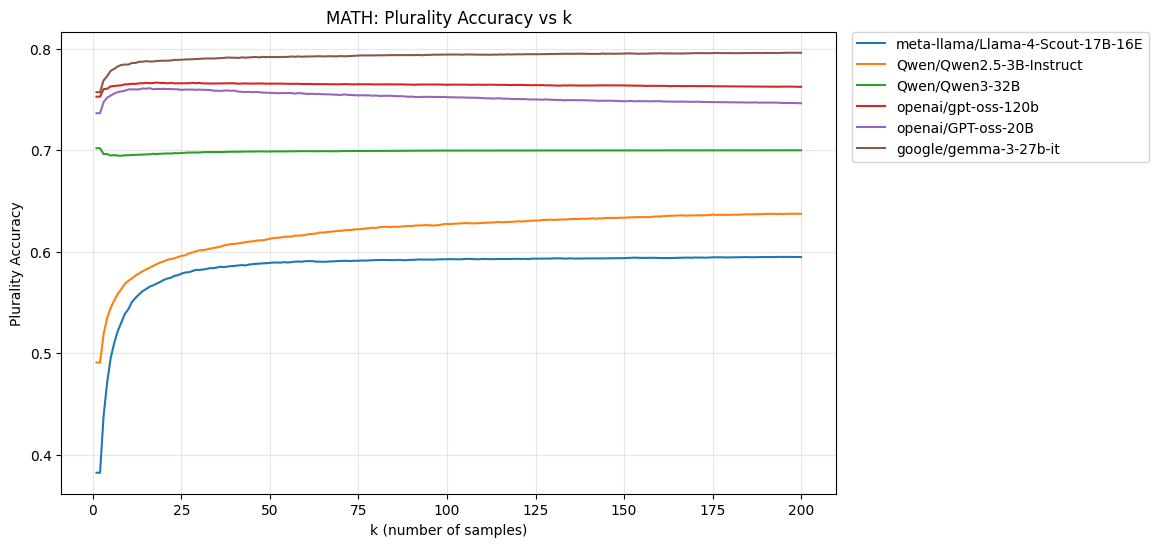

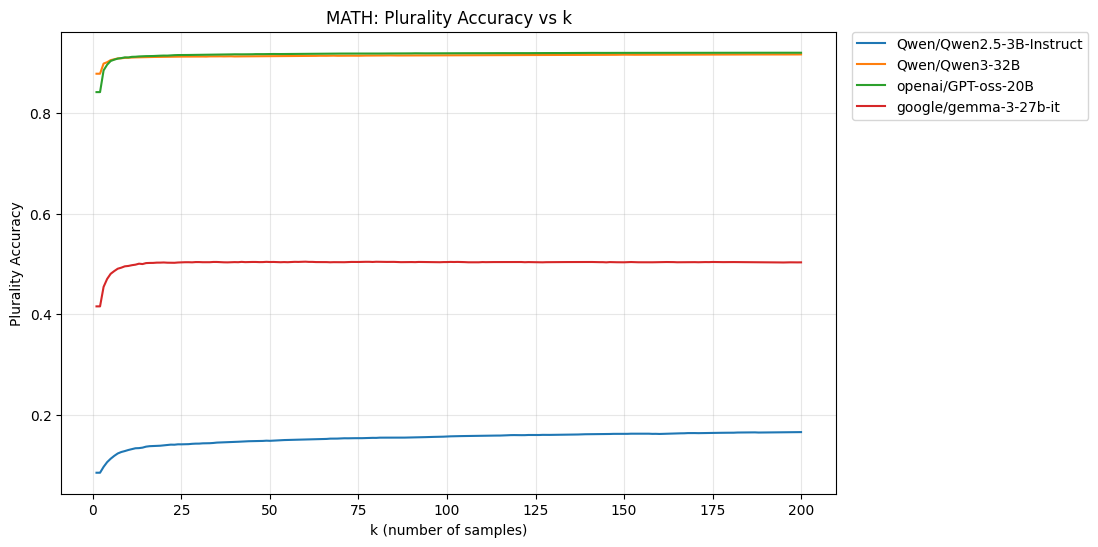

In [5]:
import matplotlib.pyplot as plt

def plot_bootstrapped_curves(results_dict, title="Plurality Accuracy vs k"):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for model, df in results_dict.items():
        ax.plot(df["k"], df["accuracy_mean"], label=model)
    
    ax.set_xlabel("k (number of samples)")
    ax.set_ylabel("Plurality Accuracy")
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.grid(True, alpha=0.3)
    
    return fig, ax


plot_bootstrapped_curves(math_results, "MATH: Plurality Accuracy vs k")
plt.show()

plot_bootstrapped_curves(aime_results, "AIME: Plurality Accuracy vs k")
plt.show()

## Some basic stats: Correctness correlation, answer distribution similarity, and just seeing the accuracy of the plurality when k=200 (fixed)

In [6]:
def correctness_correlation(df_by_model, problem_col="qid", pred_col="pred", gold_col="gold"):
    """
    For each model, compute which problems it gets right (plurality vote).
    Then correlate across models.
    """
    correctness = {}
    
    for model, df in df_by_model.items():
        correct_by_problem = {}
        for pid, g in df.groupby(problem_col):
            gold = g[gold_col].iloc[0]
            plurality = g[pred_col].value_counts().idxmax()
            correct_by_problem[pid] = int(plurality == gold)
        correctness[model] = correct_by_problem
    
    # Align problems across models
    common_problems = set.intersection(*[set(c.keys()) for c in correctness.values()])
    
    corr_df = pd.DataFrame({
        model: [correctness[model][p] for p in sorted(common_problems)]
        for model in correctness
    })
    
    return corr_df.corr()

In [7]:
import numpy as np
from collections import Counter

def answer_distribution_similarity(df_by_model, problem_col="qid", pred_col="pred"):
    """
    For each problem, compute cosine similarity between models' answer distributions.
    """
    # Get answer distributions per problem per model
    distributions = {}
    for model, df in df_by_model.items():
        distributions[model] = {}
        for pid, g in df.groupby(problem_col):
            counts = Counter(g[pred_col])
            total = sum(counts.values())
            distributions[model][pid] = {k: v/total for k, v in counts.items()}
    
    models = list(df_by_model.keys())
    common_problems = set.intersection(*[set(d.keys()) for d in distributions.values()])
    
    # Compute pairwise cosine similarities
    def cosine_sim(d1, d2):
        all_keys = set(d1.keys()) | set(d2.keys())
        v1 = np.array([d1.get(k, 0) for k in all_keys])
        v2 = np.array([d2.get(k, 0) for k in all_keys])
        denom = (np.linalg.norm(v1) * np.linalg.norm(v2))
        if denom == 0:
            return 0
        return np.dot(v1, v2) / denom
    
    # Average similarity across problems for each model pair
    n = len(models)
    sim_matrix = np.zeros((n, n))
    
    for i, m1 in enumerate(models):
        for j, m2 in enumerate(models):
            sims = [
                cosine_sim(distributions[m1][p], distributions[m2][p])
                for p in common_problems
            ]
            sim_matrix[i, j] = np.mean(sims)
    
    return pd.DataFrame(sim_matrix, index=models, columns=models)


# Usage:
corr_correct = correctness_correlation(df_by_model_math)
print("Correctness correlation:\n", corr_correct)

sim_dist = answer_distribution_similarity(df_by_model_math)
print("\nAnswer distribution similarity:\n", sim_dist)

Correctness correlation:
                                   meta-llama/Llama-4-Scout-17B-16E  \
meta-llama/Llama-4-Scout-17B-16E                          1.000000   
Qwen/Qwen2.5-3B-Instruct                                  0.792868   
Qwen/Qwen3-32B                                            0.267261   
openai/gpt-oss-120b                                       0.401478   
openai/GPT-oss-20B                                        0.446748   
google/gemma-3-27b-it                                     0.510310   

                                  Qwen/Qwen2.5-3B-Instruct  Qwen/Qwen3-32B  \
meta-llama/Llama-4-Scout-17B-16E                  0.792868        0.267261   
Qwen/Qwen2.5-3B-Instruct                          1.000000        0.359313   
Qwen/Qwen3-32B                                    0.359313        1.000000   
openai/gpt-oss-120b                               0.387518        0.654015   
openai/GPT-oss-20B                                0.537094        0.706441   
google/gemma-3-

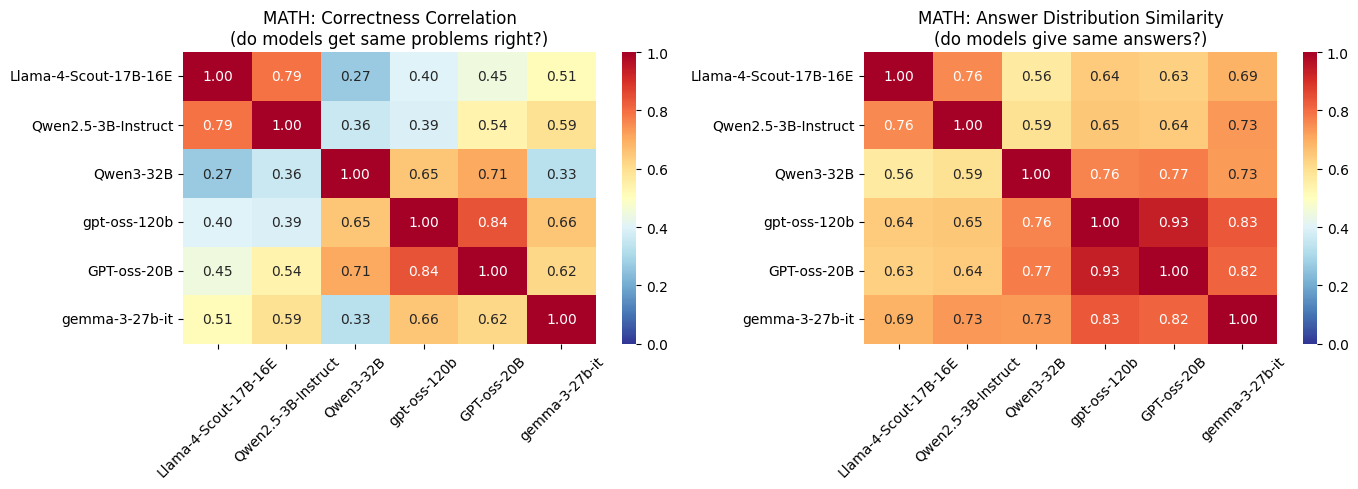

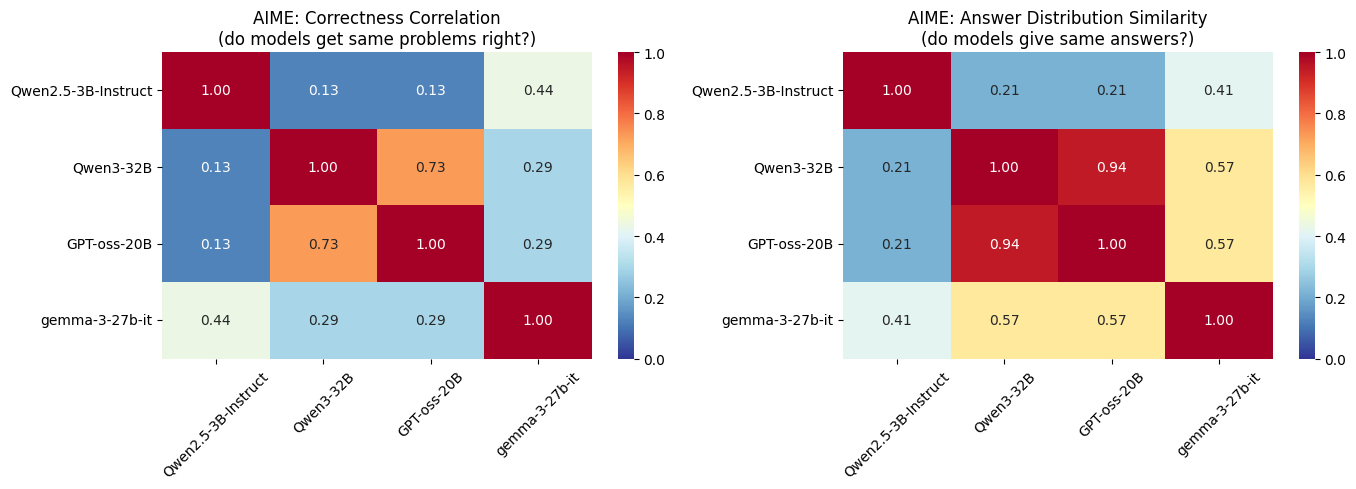

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_matrices(df_by_model, problem_col="qid", pred_col="pred", gold_col="gold", benchmark_name=""):
    # Compute correctness correlation
    correctness = {}
    for model, df in df_by_model.items():
        correct_by_problem = {}
        for pid, g in df.groupby(problem_col):
            gold = g[gold_col].iloc[0]
            plurality = g[pred_col].value_counts().idxmax()
            correct_by_problem[pid] = int(plurality == gold)
        correctness[model] = correct_by_problem
    
    common_problems = set.intersection(*[set(c.keys()) for c in correctness.values()])
    corr_df = pd.DataFrame({
        model: [correctness[model][p] for p in sorted(common_problems)]
        for model in correctness
    })
    corr_matrix = corr_df.corr()
    
    # Compute answer distribution similarity
    from collections import Counter
    distributions = {}
    for model, df in df_by_model.items():
        distributions[model] = {}
        for pid, g in df.groupby(problem_col):
            counts = Counter(g[pred_col])
            total = sum(counts.values())
            distributions[model][pid] = {k: v/total for k, v in counts.items()}
    
    def cosine_sim(d1, d2):
        all_keys = set(d1.keys()) | set(d2.keys())
        v1 = np.array([d1.get(k, 0) for k in all_keys])
        v2 = np.array([d2.get(k, 0) for k in all_keys])
        denom = (np.linalg.norm(v1) * np.linalg.norm(v2))
        return np.dot(v1, v2) / denom if denom > 0 else 0
    
    models = list(df_by_model.keys())
    n = len(models)
    sim_matrix = np.zeros((n, n))
    for i, m1 in enumerate(models):
        for j, m2 in enumerate(models):
            sims = [cosine_sim(distributions[m1][p], distributions[m2][p]) for p in common_problems]
            sim_matrix[i, j] = np.mean(sims)
    
    sim_df = pd.DataFrame(sim_matrix, index=models, columns=models)
    
    # Shorten model names for display
    short_names = [m.split("/")[-1] for m in models]
    
    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="RdYlBu_r",
        vmin=0, vmax=1,
        xticklabels=short_names,
        yticklabels=short_names,
        ax=axes[0]
    )
    axes[0].set_title(f"{benchmark_name}: Correctness Correlation\n(do models get same problems right?)")
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.heatmap(
        sim_df,
        annot=True,
        fmt=".2f",
        cmap="RdYlBu_r", 
        vmin=0, vmax=1,
        xticklabels=short_names,
        yticklabels=short_names,
        ax=axes[1]
    )
    axes[1].set_title(f"{benchmark_name}: Answer Distribution Similarity\n(do models give same answers?)")
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig, corr_matrix, sim_df


fig, corr_matrix, sim_df = plot_correlation_matrices(df_by_model_math, benchmark_name="MATH")
plt.show()

fig, corr_matrix, sim_df = plot_correlation_matrices(df_by_model_aime, benchmark_name="AIME")
plt.show()



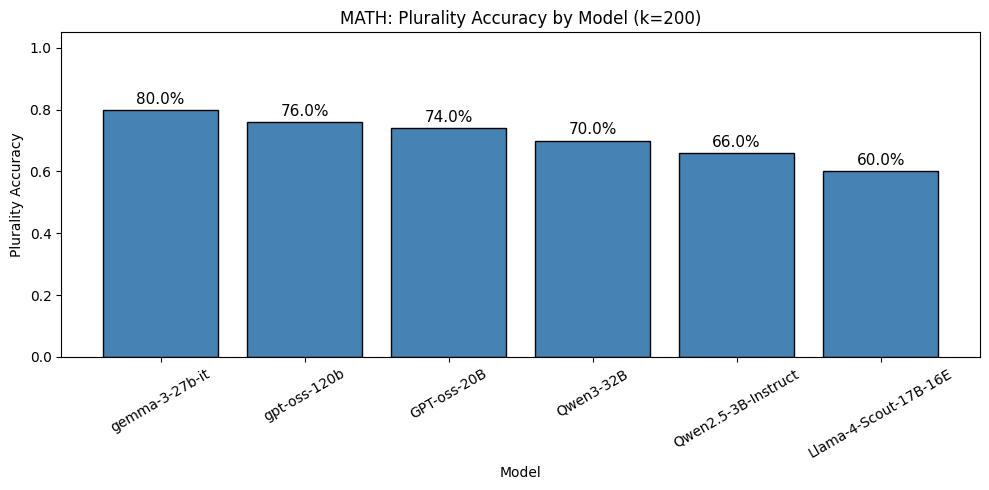

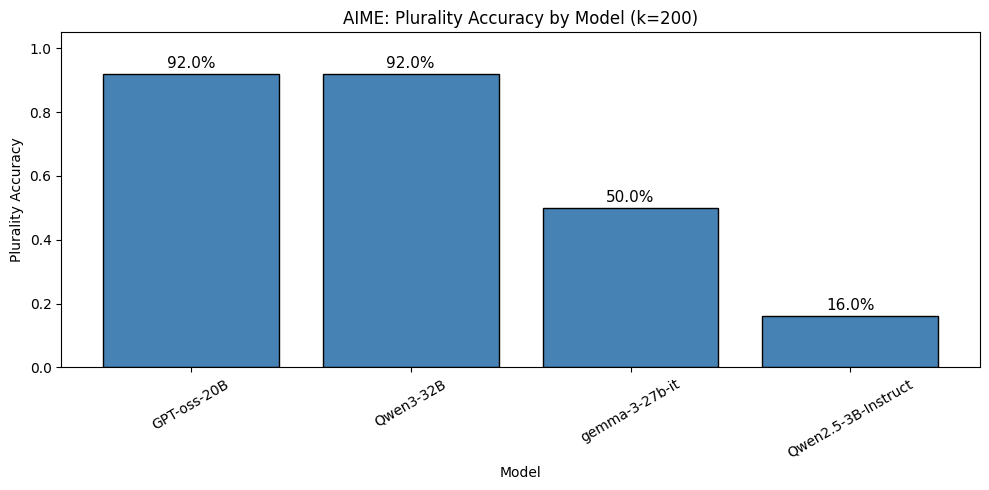

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_plurality_accuracy_by_model(df_by_model, problem_col="qid", pred_col="pred", gold_col="gold", title="Plurality Accuracy by Model (k=200)"):
    """
    Bar chart showing what fraction of problems each model gets correct
    using plurality vote over all samples.
    """
    models = []
    accuracies = []
    
    for model, df in df_by_model.items():
        correct = 0
        total = 0
        for pid, g in df.groupby(problem_col):
            gold = g[gold_col].iloc[0]
            plurality = g[pred_col].value_counts().idxmax()
            correct += (plurality == gold)
            total += 1
        
        models.append(model.split("/")[-1])  # short name
        accuracies.append(correct / total)
    
    # Sort by accuracy
    order = np.argsort(accuracies)[::-1]
    models = [models[i] for i in order]
    accuracies = [accuracies[i] for i in order]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(models, accuracies, color='steelblue', edgecolor='black')
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.1%}', ha='center', va='bottom', fontsize=11)
    
    ax.set_ylabel("Plurality Accuracy")
    ax.set_xlabel("Model")
    ax.set_title(title)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', rotation=30)
    
    plt.tight_layout()
    return fig, dict(zip(models, accuracies))


fig, accs = plot_plurality_accuracy_by_model(df_by_model_math, title="MATH: Plurality Accuracy by Model (k=200)")
plt.show()

fig, accs = plot_plurality_accuracy_by_model(df_by_model_aime, title="AIME: Plurality Accuracy by Model (k=200)")
plt.show()

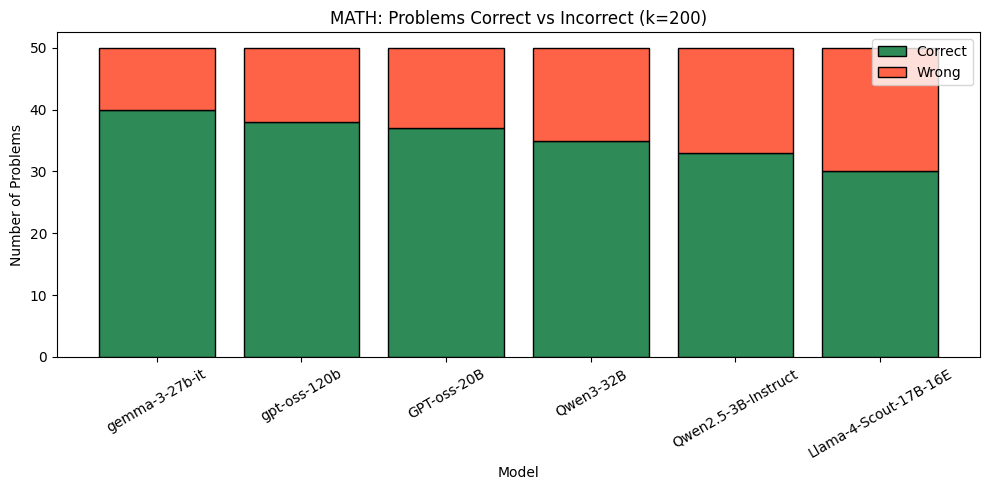

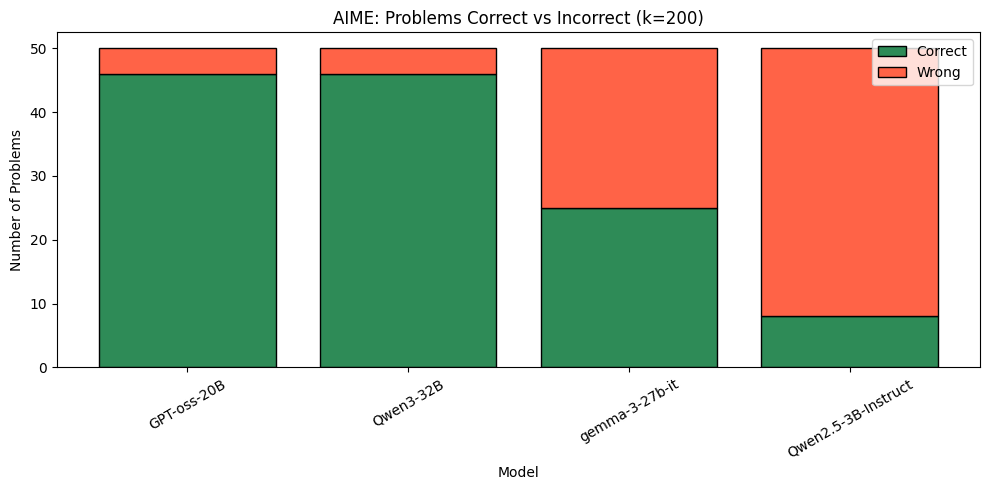

In [10]:
def plot_correct_counts(df_by_model, problem_col="qid", pred_col="pred", gold_col="gold", title="Problems Correct vs Incorrect"):
    models = []
    n_correct = []
    n_wrong = []
    
    for model, df in df_by_model.items():
        correct = 0
        total = 0
        for pid, g in df.groupby(problem_col):
            gold = g[gold_col].iloc[0]
            plurality = g[pred_col].value_counts().idxmax()
            correct += (plurality == gold)
            total += 1
        
        models.append(model.split("/")[-1])
        n_correct.append(correct)
        n_wrong.append(total - correct)
    
    # Sort by accuracy
    accs = [c/(c+w) for c, w in zip(n_correct, n_wrong)]
    order = np.argsort(accs)[::-1]
    models = [models[i] for i in order]
    n_correct = [n_correct[i] for i in order]
    n_wrong = [n_wrong[i] for i in order]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.bar(models, n_correct, label='Correct', color='seagreen', edgecolor='black')
    ax.bar(models, n_wrong, bottom=n_correct, label='Wrong', color='tomato', edgecolor='black')
    
    ax.set_ylabel("Number of Problems")
    ax.set_xlabel("Model")
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', rotation=30)
    
    plt.tight_layout()
    return fig


fig = plot_correct_counts(df_by_model_math, title="MATH: Problems Correct vs Incorrect (k=200)")
plt.show()
fig = plot_correct_counts(df_by_model_aime, title="AIME: Problems Correct vs Incorrect (k=200)")

plt.show()

### Plurality size v. probability of correctness (you might need to bin plurality size for this one)

i.e. when the responses agree with another a lot, how likely are they to be actually right? Meaning 
**is concensus likely to mean correctness**?

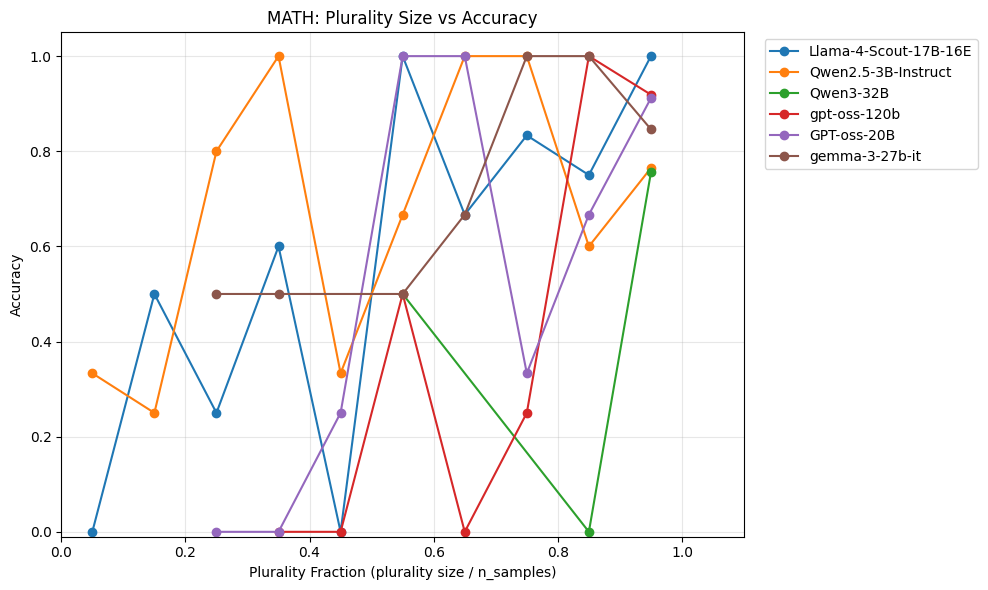

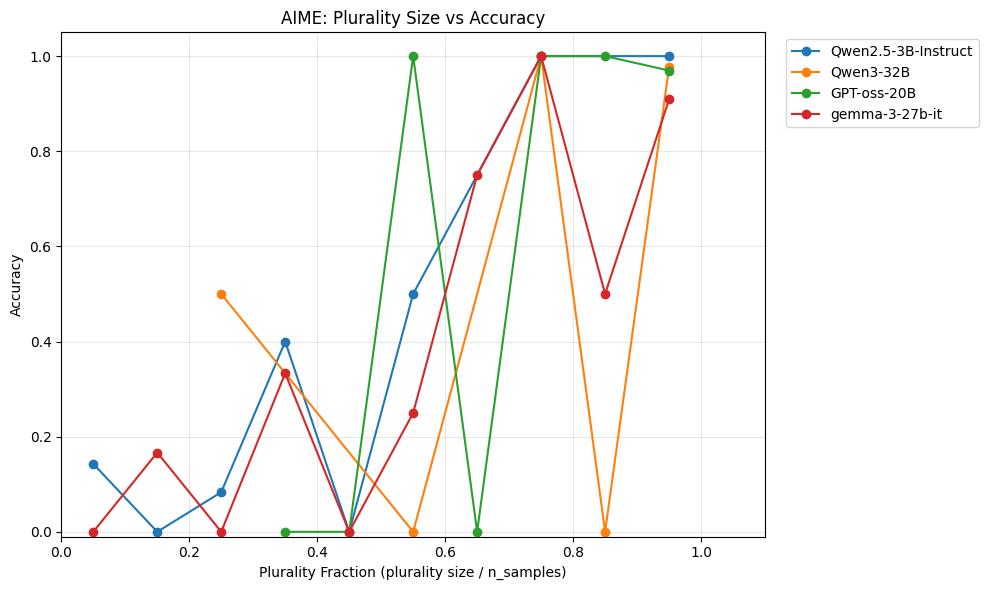

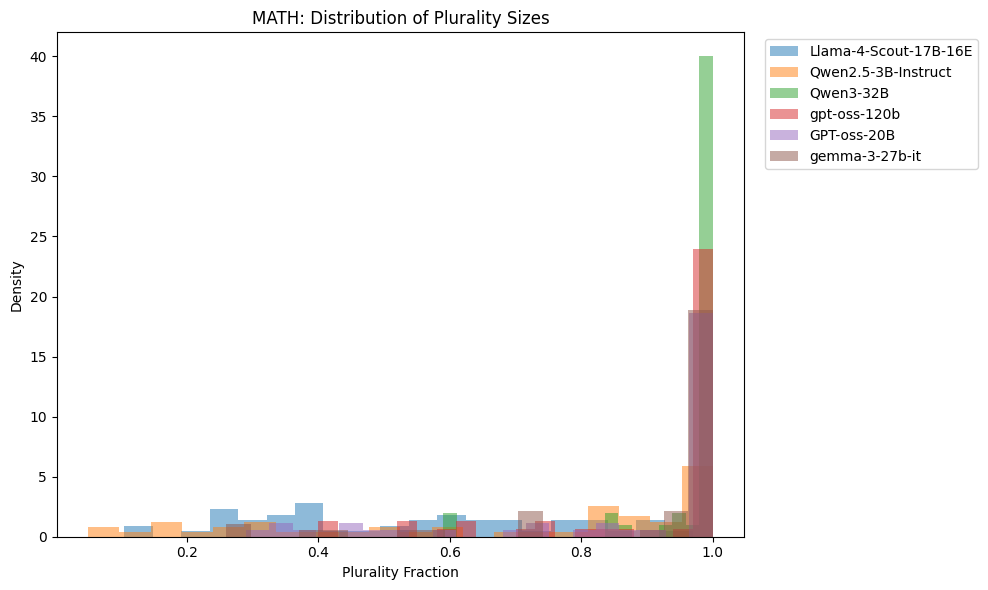

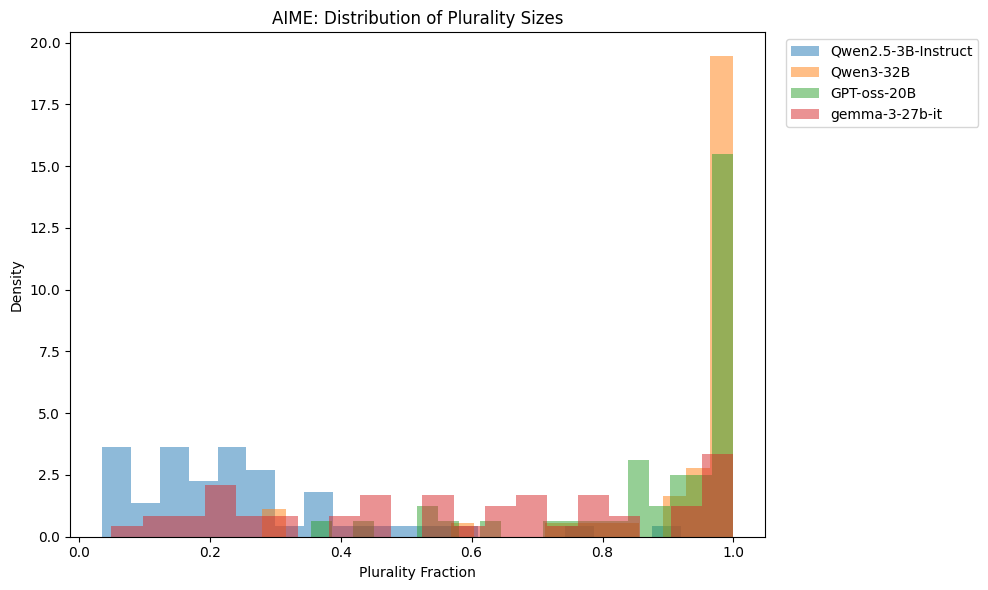

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plurality_size_vs_accuracy(
    df_by_model,
    problem_col="qid",
    pred_col="pred",
    gold_col="gold",
    n_bins=10,
    max_samples=200,
):
    """
    For each (model, problem), compute:
      - plurality_size: how many samples gave the most common answer
      - correct: whether that answer matches gold
    
    Returns a DataFrame with columns: model, problem, plurality_size, correct
    """
    rows = []
    
    for model, df in df_by_model.items():
        short_name = model.split("/")[-1]
        
        for pid, g in df.groupby(problem_col):
            gold = g[gold_col].iloc[0]
            counts = g[pred_col].value_counts()
            plurality_answer = counts.idxmax()
            plurality_size = counts.iloc[0]
            
            rows.append({
                "model": short_name,
                "problem": pid,
                "plurality_size": plurality_size,
                "plurality_frac": plurality_size / len(g),  # normalized by actual samples
                "correct": int(plurality_answer == gold),
            })
    
    return pd.DataFrame(rows)


def plot_plurality_size_vs_accuracy(
    df_by_model,
    n_bins=10,
    title="Plurality Size vs Accuracy",
    figsize=(10, 6),
):
    """
    Bin plurality sizes and plot accuracy per bin, one line per model.
    """
    data = plurality_size_vs_accuracy(df_by_model, n_bins=n_bins)
    
    # Create bins based on plurality_frac (0 to 1)
    data["bin"] = pd.cut(data["plurality_frac"], bins=n_bins, labels=False)
    
    # Compute bin edges for x-axis labels
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for model in data["model"].unique():
        model_data = data[data["model"] == model]
        
        # Accuracy per bin
        binned = model_data.groupby("bin").agg(
            accuracy=("correct", "mean"),
            count=("correct", "count"),
        ).reset_index()
        
        ax.plot(
            bin_centers[binned["bin"].astype(int)],
            binned["accuracy"],
            marker="o",
            label=model,
        )
    
    ax.set_xlabel("Plurality Fraction (plurality size / n_samples)")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.set_xlim(0, 1.1)
    ax.set_ylim(-0.01, 1.05)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, data


# Also useful: histogram of plurality sizes
def plot_plurality_size_distribution(
    df_by_model,
    n_bins=20,
    title="Distribution of Plurality Sizes",
    figsize=(10, 6),
):
    """
    Histogram showing how often models have high vs low agreement.
    """
    data = plurality_size_vs_accuracy(df_by_model)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for model in data["model"].unique():
        model_data = data[data["model"] == model]
        ax.hist(
            model_data["plurality_frac"],
            bins=n_bins,
            alpha=0.5,
            label=model,
            density=True,
        )
    
    ax.set_xlabel("Plurality Fraction")
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    
    plt.tight_layout()
    return fig, data


"""
Plurality size vs accuracy curve: Tests if higher agreement → higher accuracy (should slope upward if models are well-calibrated)
"""
fig1, data = plot_plurality_size_vs_accuracy(df_by_model_math, title="MATH: Plurality Size vs Accuracy")
plt.show()

# For AIME:
fig3, data_aime = plot_plurality_size_vs_accuracy(df_by_model_aime, title="AIME: Plurality Size vs Accuracy")
plt.show()

""" 
Distribution of plurality sizes: Shows whether models tend to be confident (mass near 1.0) or uncertain (mass spread out)
"""

fig2, _ = plot_plurality_size_distribution(df_by_model_math, title="MATH: Distribution of Plurality Sizes")
plt.show()

fig4, _ = plot_plurality_size_distribution(df_by_model_aime, title="AIME: Distribution of Plurality Sizes")
plt.show()

## Plurality size vs probability of being correct

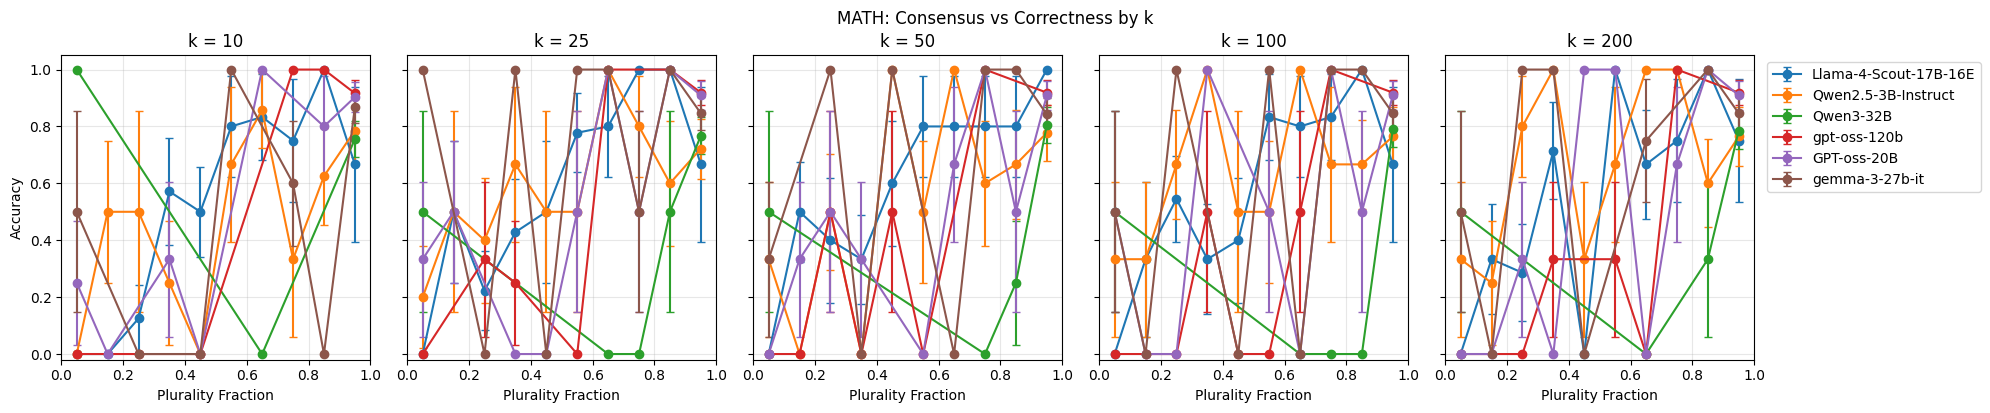

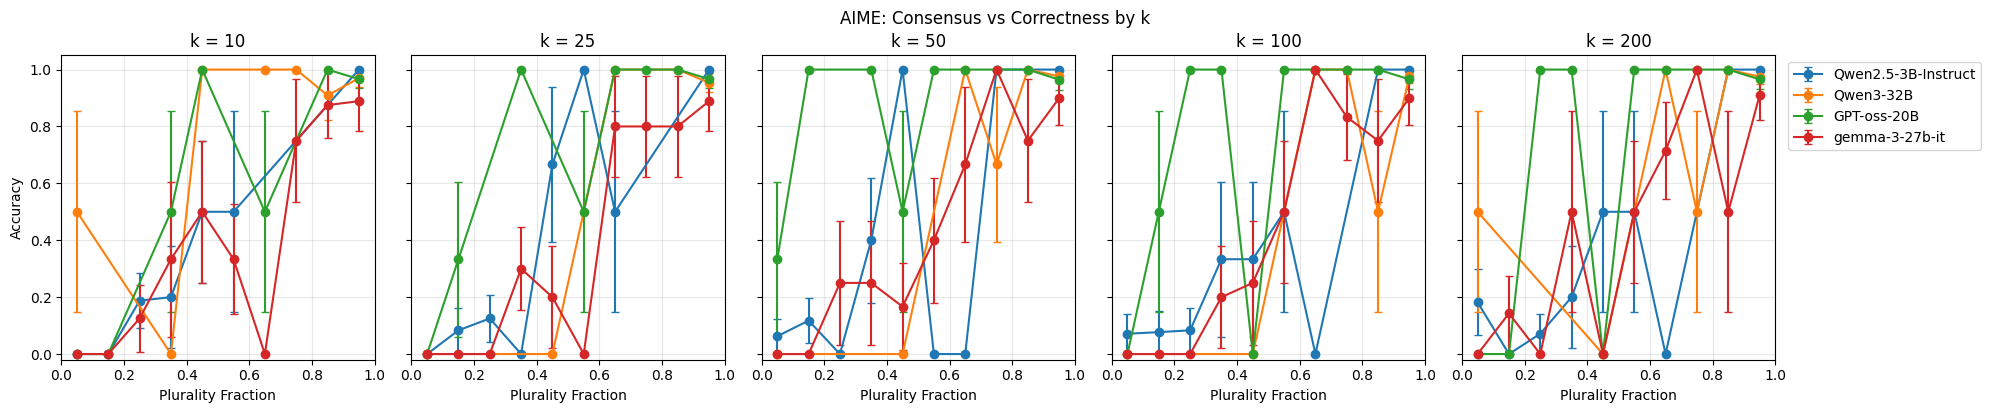

In [12]:
# def plot_consensus_vs_correctness_by_k(
#     df_by_model,
#     k_values=[10, 25, 50, 100, 200],
#     n_bins=10,
#     problem_col="qid",
#     pred_col="pred",
#     gold_col="gold",
#     model_filter=None,  # optionally plot one model
# ):
#     """
#     For each k, compute plurality fraction and correctness, then plot
#     accuracy vs plurality fraction.
#     """
#     fig, axes = plt.subplots(1, len(k_values), figsize=(4 * len(k_values), 4), sharey=True)
    
#     for ax, k in zip(axes, k_values):
#         for model, df in df_by_model.items():
#             if model_filter and model_filter not in model:
#                 continue
            
#             short_name = model.split("/")[-1]
#             rows = []
            
#             for pid, g in df.groupby(problem_col):
#                 # Take first k samples (after shuffling)
#                 g_k = g.head(k)
#                 gold = g_k[gold_col].iloc[0]
#                 counts = g_k[pred_col].value_counts()
#                 plurality = counts.idxmax()
#                 plurality_frac = counts.iloc[0] / k
#                 correct = int(plurality == gold)
#                 rows.append({"plurality_frac": plurality_frac, "correct": correct})
            
#             data = pd.DataFrame(rows)
#             data["bin"] = pd.cut(data["plurality_frac"], bins=n_bins, labels=False)
            
#             bin_edges = np.linspace(0, 1, n_bins + 1)
#             bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
#             binned = data.groupby("bin").agg(
#                 accuracy=("correct", "mean"),
#                 count=("correct", "count"),
#             ).reset_index()
            
#             ax.plot(
#                 bin_centers[binned["bin"].astype(int)],
#                 binned["accuracy"],
#                 marker="o",
#                 label=short_name,
#             )
        
#         ax.set_xlabel("Plurality Fraction")
#         ax.set_title(f"k = {k}")
#         ax.set_xlim(0, 1)
#         ax.set_ylim(-0.02, 1.05)
#         ax.grid(True, alpha=0.3)
    
#     axes[0].set_ylabel("Accuracy")
#     axes[-1].legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    
#     plt.tight_layout()
#     return fig

def plot_consensus_vs_correctness_by_k(
    df_by_model,
    k_values=[10, 25, 50, 100, 200],
    n_bins=10,
    problem_col="qid",
    pred_col="pred",
    gold_col="gold",
    model_filter=None,  # optionally plot one model
):
    """
    For each k, compute plurality fraction and correctness, then plot
    accuracy vs plurality fraction with error bars.
    """
    fig, axes = plt.subplots(1, len(k_values), figsize=(4 * len(k_values), 4), sharey=True)
    
    for ax, k in zip(axes, k_values):
        for model, df in df_by_model.items():
            if model_filter and model_filter not in model:
                continue
            
            short_name = model.split("/")[-1]
            rows = []
            
            for pid, g in df.groupby(problem_col):
                # Take first k samples (after shuffling)
                g_k = g.head(k)
                gold = g_k[gold_col].iloc[0]
                counts = g_k[pred_col].value_counts()
                plurality = counts.idxmax()
                plurality_frac = counts.iloc[0] / k
                correct = int(plurality == gold)
                rows.append({"plurality_frac": plurality_frac, "correct": correct})
            
            data = pd.DataFrame(rows)
            data["bin"] = pd.cut(data["plurality_frac"], bins=n_bins, labels=False)
            
            bin_edges = np.linspace(0, 1, n_bins + 1)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            binned = data.groupby("bin").agg(
                accuracy=("correct", "mean"),
                count=("correct", "count"),
            ).reset_index()
            
            # Calculate standard error: SE = sqrt(p * (1-p) / n)
            binned["se"] = np.sqrt(
                binned["accuracy"] * (1 - binned["accuracy"]) / binned["count"]
            )
            
            x = bin_centers[binned["bin"].astype(int)]
            y = binned["accuracy"]
            yerr = binned["se"]
            
            ax.errorbar(
                x,
                y,
                yerr=yerr,
                marker="o",
                capsize=3,
                label=short_name,
            )
        
        ax.set_xlabel("Plurality Fraction")
        ax.set_title(f"k = {k}")
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.02, 1.05)
        ax.grid(True, alpha=0.3)
    
    axes[0].set_ylabel("Accuracy")
    axes[-1].legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    
    plt.tight_layout()
    return fig


# Usage:
fig = plot_consensus_vs_correctness_by_k(df_by_model_math, k_values=[10, 25, 50, 100, 200])
plt.suptitle("MATH: Consensus vs Correctness by k", y=1.02)
plt.show()

fig = plot_consensus_vs_correctness_by_k(df_by_model_aime, k_values=[10, 25, 50, 100, 200])
plt.suptitle("AIME: Consensus vs Correctness by k", y=1.02)
plt.show()

## Entropy of the responses (so \sum_{answers given} -P(that answer is given)logP(that answer is given)) v. correctness of the plurality.

#### Namely, when the model is confident (low entropy), is it usually right, and vice versa? 

In [13]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from collections import Counter

# def compute_entropy(counts):
#     """Compute entropy from a Counter or dict of counts."""
#     total = sum(counts.values())
#     if total == 0:
#         return 0
#     probs = [c / total for c in counts.values() if c > 0]
#     return -sum(p * np.log2(p) for p in probs)


# def entropy_vs_correctness_data(
#     df,
#     k,
#     problem_col="qid",
#     pred_col="pred",
#     gold_col="gold",
#     rng=None,
#     resample=False,
# ):
#     """
#     For a single model's df, compute entropy and correctness at given k.
#     Returns list of (entropy, correct) tuples.
#     """
#     if rng is None:
#         rng = np.random.default_rng()
    
#     results = []
    
#     for pid, g in df.groupby(problem_col):
#         # Optionally resample with replacement
#         if resample:
#             g = g.sample(n=len(g), replace=True, random_state=rng.integers(1e9))
        
#         # Take first k samples
#         g_k = g.head(k)
#         gold = g_k[gold_col].iloc[0]
        
#         counts = Counter(g_k[pred_col])
#         plurality = counts.most_common(1)[0][0]
#         correct = int(plurality == gold)
        
#         entropy = compute_entropy(counts)
#         max_entropy = np.log2(k)  # theoretical max if all k are different
#         entropy_norm = entropy / max_entropy if max_entropy > 0 else 0
        
#         results.append({
#             "entropy": entropy,
#             "entropy_norm": entropy_norm,
#             "correct": correct,
#         })
    
#     return results


# def bin_and_compute_accuracy(data, n_bins=10, entropy_col="entropy_norm"):
#     """Bin by entropy and compute accuracy per bin."""
#     df = pd.DataFrame(data)
#     df["bin"] = pd.cut(df[entropy_col], bins=n_bins, labels=False)
    
#     binned = df.groupby("bin").agg(
#         accuracy=("correct", "mean"),
#         count=("correct", "count"),
#     ).reset_index()
    
#     return binned


# def entropy_vs_correctness_bootstrapped(
#     df_by_model,
#     k_values=[10, 25, 50, 100, 200],
#     n_bins=10,
#     n_bootstrap=1000,
#     ci_lower=2.5,
#     ci_upper=97.5,
#     seed=0,
#     problem_col="qid",
#     pred_col="pred",
#     gold_col="gold",
# ):
#     """
#     Compute entropy vs correctness curves with bootstrap CIs.
    
#     Returns:
#         results: dict[model][k] -> DataFrame with bin, accuracy_mean, ci_lower, ci_upper
#         raw: dict[model][k] -> array of shape (n_bootstrap, n_bins) with accuracies
#     """
#     rng = np.random.default_rng(seed)
    
#     bin_centers = (np.linspace(0, 1, n_bins + 1)[:-1] + np.linspace(0, 1, n_bins + 1)[1:]) / 2
    
#     results = {}
#     raw = {}
    
#     for model, df in df_by_model.items():
#         short_name = model.split("/")[-1]
#         print(f"Bootstrapping {short_name}...")
        
#         results[short_name] = {}
#         raw[short_name] = {}
        
#         for k in k_values:
#             # Store accuracy per bin for each bootstrap
#             boot_accs = np.full((n_bootstrap, n_bins), np.nan)
            
#             for b in range(n_bootstrap):
#                 data = entropy_vs_correctness_data(
#                     df, k, problem_col, pred_col, gold_col,
#                     rng=rng, resample=True
#                 )
#                 binned = bin_and_compute_accuracy(data, n_bins, "entropy_norm")
                
#                 for _, row in binned.iterrows():
#                     bin_idx = int(row["bin"])
#                     boot_accs[b, bin_idx] = row["accuracy"]
            
#             # Aggregate across bootstraps
#             results[short_name][k] = pd.DataFrame({
#                 "bin_center": bin_centers,
#                 "accuracy_mean": np.nanmean(boot_accs, axis=0),
#                 "accuracy_median": np.nanmedian(boot_accs, axis=0),
#                 f"ci_{ci_lower}": np.nanpercentile(boot_accs, ci_lower, axis=0),
#                 f"ci_{ci_upper}": np.nanpercentile(boot_accs, ci_upper, axis=0),
#             })
#             raw[short_name][k] = boot_accs
    
#     return results, raw


# def plot_entropy_vs_correctness(
#     results,
#     k_values=[10, 25, 50, 100, 200],
#     title="Entropy vs Correctness",
#     figsize=None,
# ):
#     """Plot entropy vs correctness curves, faceted by k."""
#     if figsize is None:
#         figsize = (4 * len(k_values), 4)
    
#     fig, axes = plt.subplots(1, len(k_values), figsize=figsize, sharey=True)
    
#     models = list(results.keys())
    
#     for ax, k in zip(axes, k_values):
#         for model in models:
#             df = results[model][k]
            
#             # Drop NaN bins
#             valid = ~df["accuracy_mean"].isna()
            
#             ax.plot(
#                 df.loc[valid, "bin_center"],
#                 df.loc[valid, "accuracy_mean"],
#                 marker="o",
#                 label=model,
#             )
#             # ax.fill_between(
#             #     df.loc[valid, "bin_center"],
#             #     df.loc[valid, "ci_2.5"],
#             #     df.loc[valid, "ci_97.5"],
#             #     alpha=0.2,
#             # )
        
#         ax.set_xlabel("Normalized Entropy")
#         ax.set_title(f"k = {k}")
#         ax.set_xlim(0, 1)
#         ax.set_ylim(0, 1.05)
#         ax.grid(True, alpha=0.3)
    
#     axes[0].set_ylabel("Accuracy")
#     axes[-1].legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    
#     plt.suptitle(title, y=1.02)
#     plt.tight_layout()
#     return fig


# # Usage:
# results_math, raw_math = entropy_vs_correctness_bootstrapped(
#     df_by_model_math, 
#     k_values=[10, 25, 50, 100, 200],
#     n_bootstrap=1000,
# )

# fig = plot_entropy_vs_correctness(results_math, title="MATH: Entropy vs Correctness")
# plt.show()

# # For AIME:
# results_aime, raw_aime = entropy_vs_correctness_bootstrapped(
#     df_by_model_aime,
#     k_values=[10, 25, 50, 100, 200],
#     n_bootstrap=1000,
# )

# fig = plot_entropy_vs_correctness(results_aime, title="AIME: Entropy vs Correctness")
# plt.show()

Bootstrapping Llama-4-Scout-17B-16E...
Bootstrapping Qwen2.5-3B-Instruct...
Bootstrapping Qwen3-32B...


/tmp/user/23557/ipykernel_2259466/3363569231.py:123: RuntimeWarning: Mean of empty slice
  "accuracy_mean": np.nanmean(boot_accs, axis=0),
/lfs/skampere1/0/jchud/miniconda3/envs/poll/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1217: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
/lfs/skampere1/0/jchud/miniconda3/envs/poll/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


Bootstrapping gpt-oss-120b...
Bootstrapping GPT-oss-20B...
Bootstrapping gemma-3-27b-it...


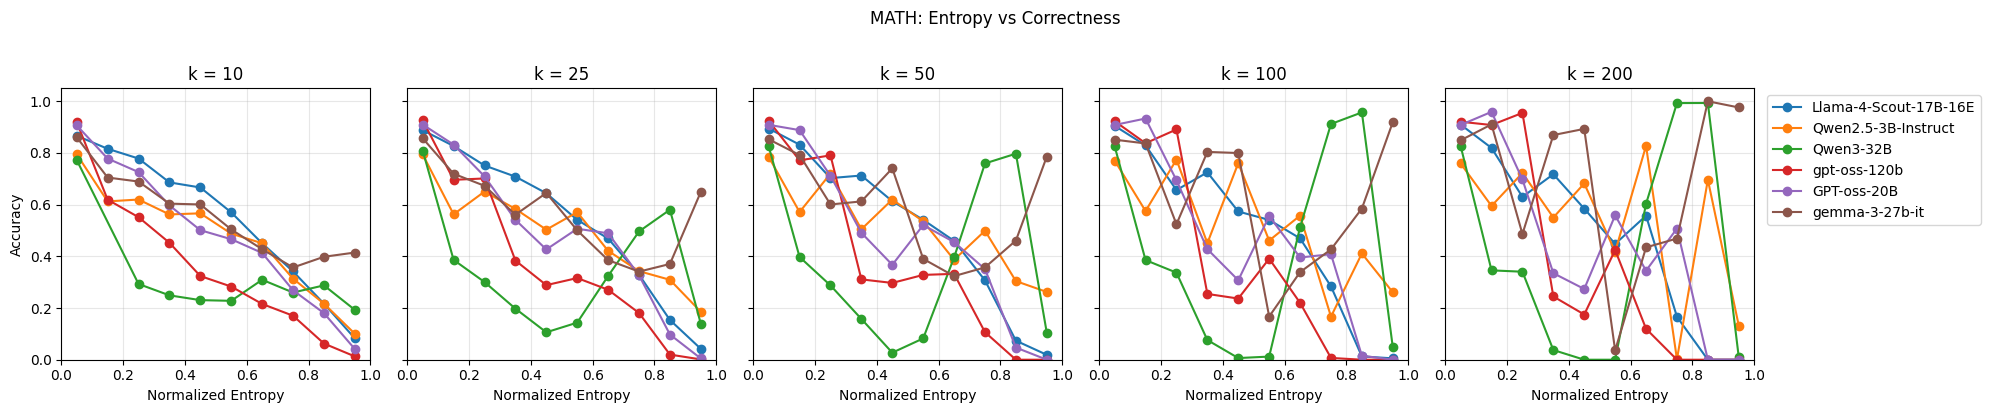

Bootstrapping Qwen2.5-3B-Instruct...
Bootstrapping Qwen3-32B...
Bootstrapping GPT-oss-20B...
Bootstrapping gemma-3-27b-it...


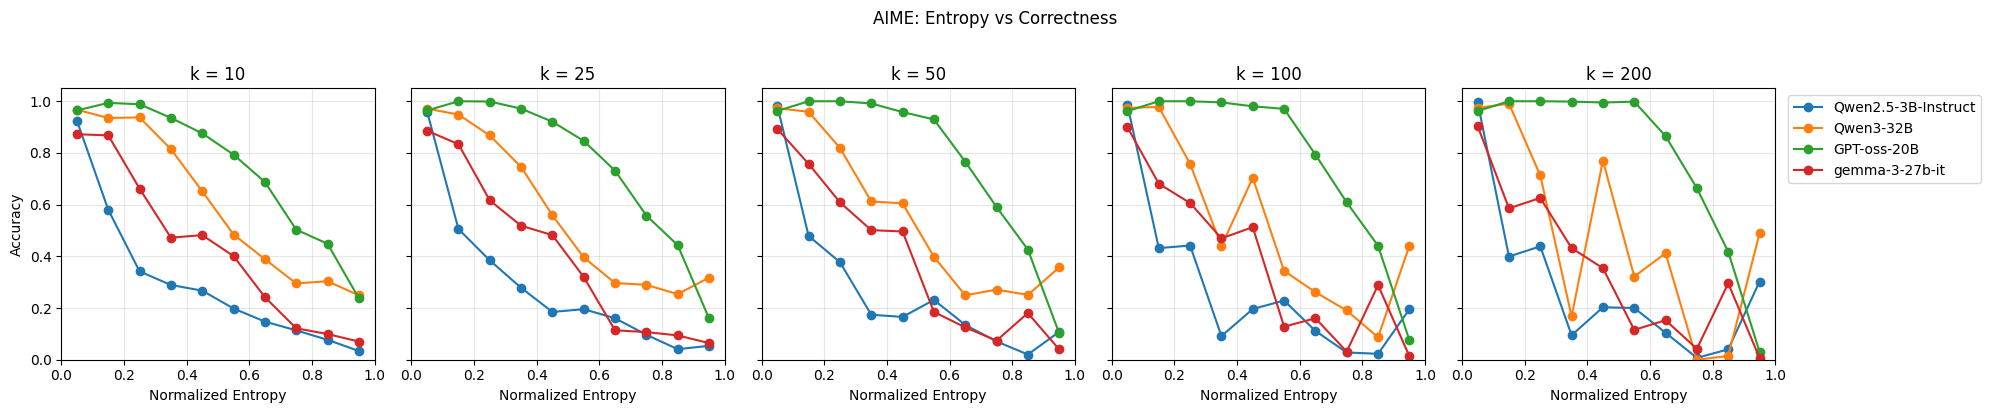

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def compute_entropy(counts):
    """Compute entropy from a Counter or dict of counts."""
    total = sum(counts.values())
    if total == 0:
        return 0
    probs = [c / total for c in counts.values() if c > 0]
    return -sum(p * np.log2(p) for p in probs)


def entropy_vs_correctness_data(
    df,
    k,
    problem_col="qid",
    pred_col="pred",
    gold_col="gold",
    rng=None,
    resample=False,
):
    """
    For a single model's df, compute entropy and correctness at given k.
    Returns list of (entropy, correct) tuples.
    """
    if rng is None:
        rng = np.random.default_rng()
    
    results = []
    
    for pid, g in df.groupby(problem_col):
        # Optionally resample with replacement
        if resample:
            g = g.sample(n=len(g), replace=True, random_state=rng.integers(1e9))
        
        # Take first k samples
        g_k = g.head(k)
        gold = g_k[gold_col].iloc[0]
        
        counts = Counter(g_k[pred_col])
        plurality = counts.most_common(1)[0][0]
        correct = int(plurality == gold)
        
        entropy = compute_entropy(counts)
        max_entropy = np.log2(k)  # theoretical max if all k are different
        entropy_norm = entropy / max_entropy if max_entropy > 0 else 0
        
        results.append({
            "entropy": entropy,
            "entropy_norm": entropy_norm,
            "correct": correct,
        })
    
    return results


def bin_and_compute_accuracy(data, n_bins=10, entropy_col="entropy_norm"):
    """Bin by entropy and compute accuracy per bin."""
    df = pd.DataFrame(data)
    df["bin"] = pd.cut(df[entropy_col], bins=n_bins, labels=False)
    
    binned = df.groupby("bin").agg(
        accuracy=("correct", "mean"),
        count=("correct", "count"),
    ).reset_index()
    
    return binned


def entropy_vs_correctness_bootstrapped(
    df_by_model,
    k_values=[10, 25, 50, 100, 200],
    n_bins=10,
    n_bootstrap=100,
    ci_lower=2.5,
    ci_upper=97.5,
    seed=0,
    problem_col="qid",
    pred_col="pred",
    gold_col="gold",
):
    """
    Compute entropy vs correctness curves with bootstrap CIs.
    
    Returns:
        results: dict[model][k] -> DataFrame with bin, accuracy_mean, ci_lower, ci_upper
        raw: dict[model][k] -> array of shape (n_bootstrap, n_bins) with accuracies
    """
    rng = np.random.default_rng(seed)
    
    bin_centers = (np.linspace(0, 1, n_bins + 1)[:-1] + np.linspace(0, 1, n_bins + 1)[1:]) / 2
    
    results = {}
    raw = {}
    
    for model, df in df_by_model.items():
        short_name = model.split("/")[-1]
        print(f"Bootstrapping {short_name}...")
        
        results[short_name] = {}
        raw[short_name] = {}
        
        for k in k_values:
            # Store accuracy per bin for each bootstrap
            boot_accs = np.full((n_bootstrap, n_bins), np.nan)
            
            for b in range(n_bootstrap):
                data = entropy_vs_correctness_data(
                    df, k, problem_col, pred_col, gold_col,
                    rng=rng, resample=True
                )
                binned = bin_and_compute_accuracy(data, n_bins, "entropy_norm")
                
                for _, row in binned.iterrows():
                    bin_idx = int(row["bin"])
                    boot_accs[b, bin_idx] = row["accuracy"]
            
            # Aggregate across bootstraps
            results[short_name][k] = pd.DataFrame({
                "bin_center": bin_centers,
                "accuracy_mean": np.nanmean(boot_accs, axis=0),
                "accuracy_median": np.nanmedian(boot_accs, axis=0),
                f"ci_{ci_lower}": np.nanpercentile(boot_accs, ci_lower, axis=0),
                f"ci_{ci_upper}": np.nanpercentile(boot_accs, ci_upper, axis=0),
            })
            raw[short_name][k] = boot_accs
    
    return results, raw


def plot_entropy_vs_correctness(
    results,
    k_values=[10, 25, 50, 100, 200],
    title="Entropy vs Correctness",
    figsize=None,
):
    """Plot entropy vs correctness curves, faceted by k."""
    if figsize is None:
        figsize = (4 * len(k_values), 4)
    
    fig, axes = plt.subplots(1, len(k_values), figsize=figsize, sharey=True)
    
    models = list(results.keys())
    
    for ax, k in zip(axes, k_values):
        for model in models:
            df = results[model][k]
            
            # Drop NaN bins
            valid = ~df["accuracy_mean"].isna()
            
            ax.plot(
                df.loc[valid, "bin_center"],
                df.loc[valid, "accuracy_mean"],
                marker="o",
                label=model,
            )
            # ax.fill_between(
            #     df.loc[valid, "bin_center"],
            #     df.loc[valid, "ci_2.5"],
            #     df.loc[valid, "ci_97.5"],
            #     alpha=0.2,
            # )
        
        ax.set_xlabel("Normalized Entropy")
        ax.set_title(f"k = {k}")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)
    
    axes[0].set_ylabel("Accuracy")
    axes[-1].legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    return fig


# Usage:
results_math, raw_math = entropy_vs_correctness_bootstrapped(
    df_by_model_math, 
    k_values=[10, 25, 50, 100, 200],
    n_bootstrap=1000,
)

fig = plot_entropy_vs_correctness(results_math, title="MATH: Entropy vs Correctness")
plt.show()

# For AIME:
results_aime, raw_aime = entropy_vs_correctness_bootstrapped(
    df_by_model_aime,
    k_values=[10, 25, 50, 100, 200],
    n_bootstrap=1000,
)

fig = plot_entropy_vs_correctness(results_aime, title="AIME: Entropy vs Correctness")
plt.show()